In [2]:
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import sys

%matplotlib inline  

matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)
 
vocab = set()
docs = []
 
D = 472 # number of documents
K = 10 # number of topics
 
# open each file; convert everything to lowercase and strip non-letter symbols; split into words
for fileind in range( 1, D+1 ):
    foo = open( 'data/gibbs/output%04d.txt' % fileind ).read()    
    tmp = re.sub( '[^a-z ]+', ' ', foo.lower() ).split()
    docs.append( tmp )
 
    for w in tmp:
        vocab.add( w )
 
# vocab now has unique words
# give each word in the vocab a unique id
ind = 0
vhash = {}
vindhash = {}
for i in list(vocab):
    vhash[i] = ind
    vindhash[ind] = i
    ind += 1
 
# size of our vocabulary
V = ind
 
# reprocess each document and re-represent it as a list of word ids
 
docs_i = []
for d in docs:
    dinds = []
    for w in d:
        dinds.append( vhash[w] )
    docs_i.append( dinds )
 
# ======================================================================
civk = np.zeros((D, V, K)) #Documents, Words, Topics

In [3]:
def randomly_assign_topics( docs_i, K ):
    qs = []
    for row in xrange(len(docs_i)):
        qs.append([])
        for col in xrange(len(docs_i[row])):
            qs[row].append(np.random.randint(K))
            
            civk[row, docs_i[row][col], qs[row][col]] += 1
    return qs
    
def compute_data_likelihood( docs, qs, topics, pdtm ):
    ll = 0
    for i in xrange(len(docs)):
        for j_ind in range(0, len(docs[i])):
            ll += np.log(topics[docs[i][j_ind], qs[i][j_ind]])
    return ll
 
def get_cik():
    return np.sum(civk, axis=1)

def get_cvk():
    return np.sum(civk, axis=0)

def get_ck(cvk):
    return np.sum(cvk, axis=0)

def initialize_topics(K, gammas, topics):
    for row in xrange(K):
        topics[:,row] = np.random.dirichlet( gammas )

def initialize_pdtm(D, alphas, pdtm):
    for row in xrange(D): #For the document length
        pdtm[:,row] = np.random.dirichlet( alphas )

def resample_topics(K, gammas, topics):
    cvk = get_cvk()
    for row in xrange(K):
        topics[:,row] = np.random.dirichlet( gammas + cvk[:,row] )
        
def resample_pdtm(D, alphas, pdtm):
    cik = get_cik()
    for row in xrange(D): #For the document length
        pdtm[:,row] = np.random.dirichlet( alphas + cik[row] )
        
def resample_qs(docs_i, D, K, topics, pdtm):
    for i in xrange(D):
        for j in xrange(len(docs_i[i])):
            docLikelihood = pdtm[:,i]
            wordLikelihood = topics[docs_i[i][j]]
            samplingProb = docLikelihood * wordLikelihood
            normalizedProb = samplingProb / np.sum(samplingProb)
            newQSval = np.random.choice(K, size=1, p=normalizedProb)
            civk[i, docs_i[i][j], newQSval] += 1
            civk[i, docs_i[i][j], qs[i][j]] -= 1
            qs[i][j] = newQSval
            
def resample_collapsed_qs(docs_i, D, K, topics, pdtm):
    cvk = get_cvk()
    cik = get_cik()
    ck = get_ck(cvk)
    for i, doc in enumerate(docs_i):
        for l,v in enumerate(doc):
            
            prev = qs[i][l]
            cvk[v, prev] -= 1
            cik[i, prev] -= 1
            ck[prev] -= 1
            
            f1 = (cvk[v] + gammas[v]) / (ck + V * gammas[v])
            f2 = (cik[i] + alphas) / (len(docs_i[i]) + K* alphas)
            
            tmp = f1 * f2
            
            tmp = np.array(tmp)
            tmp = tmp / np.sum(tmp)
            
            new = np.random.choice(K, p = tmp)
            
            qs[i][l] = new
            civk[i, docs_i[i][l], prev] -= 1
            civk[i, docs_i[i][l], new] += 1
            
            cvk[v, new] += 1
            cik[i, new] += 1
            ck[new] += 1
            

In [4]:
qs = randomly_assign_topics( docs_i, K )


In [5]:
alphas = np.ones((K,1))[:,0]
gammas = np.ones((V,1))[:,0]
 
# topic distributions   BK?
topics = np.zeros((V,K))

resample_topics(K,gammas, topics)
 
# per-document-topic distributions  PDTM?
pdtm = np.zeros((K,D))  

resample_pdtm(D, alphas, pdtm)

ps = []
 
for iters in range(0,100):
    p = compute_data_likelihood( docs_i, qs, topics, pdtm )
    
    ps.append(p)
    sys.stdout.write("\rIter %d, p=%.2f" % (iters,p))
 
    # resample per-word topic assignments qs
    resample_qs(docs_i, D, K, topics, pdtm)
 
    # resample per-document topic mixtures pdtm
    resample_pdtm(D, alphas, pdtm)
 
    # resample topics
    resample_topics(K, gammas, topics)

Iter 99, p=-5215507.42

## Basic Gibbs PDTM Graph 

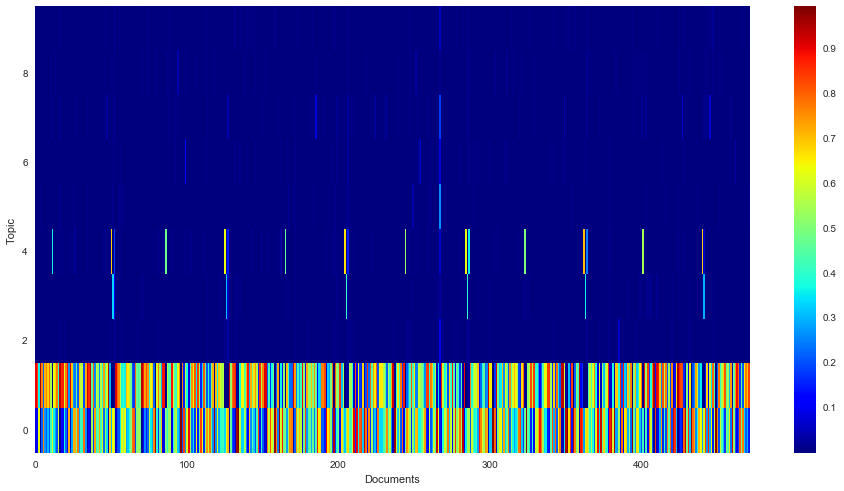

In [6]:
fig2 = plt.figure("Per Document Topic Mixtures")
ax2 = fig2.add_subplot(111)
ax2.set_xlabel("Documents")
ax2.set_ylabel("Topic")
cax2 = ax2.matshow(pdtm, aspect='auto', cmap = plt.cm.jet, origin='lower')
ax2.grid('off')
ax2.xaxis.set_ticks_position('bottom')
fig2.colorbar(cax2)
plt.show()

In [12]:
qs = randomly_assign_topics( docs_i, K )
alphas = np.ones((K,1))[:,0]
gammas = np.ones((V,1))[:,0]
 
# topic distributions   BK?
topics = np.zeros((V,K))

resample_topics(K,gammas, topics)
 
# per-document-topic distributions  PDTM?
pdtm = np.zeros((K,D))  

resample_pdtm(D, alphas, pdtm)

c_ps = []
 
for iters in range(0,100):
    p = compute_data_likelihood( docs_i, qs, topics, pdtm )
    
    c_ps.append(p)
    sys.stdout.write("\rIter %d, p=%.2f" % (iters,p))
 
    # resample per-word topic assignments qs
    resample_collapsed_qs(docs_i, D, K, topics, pdtm)

Iter 99, p=-5247137.34

## Log Posterior Over Time

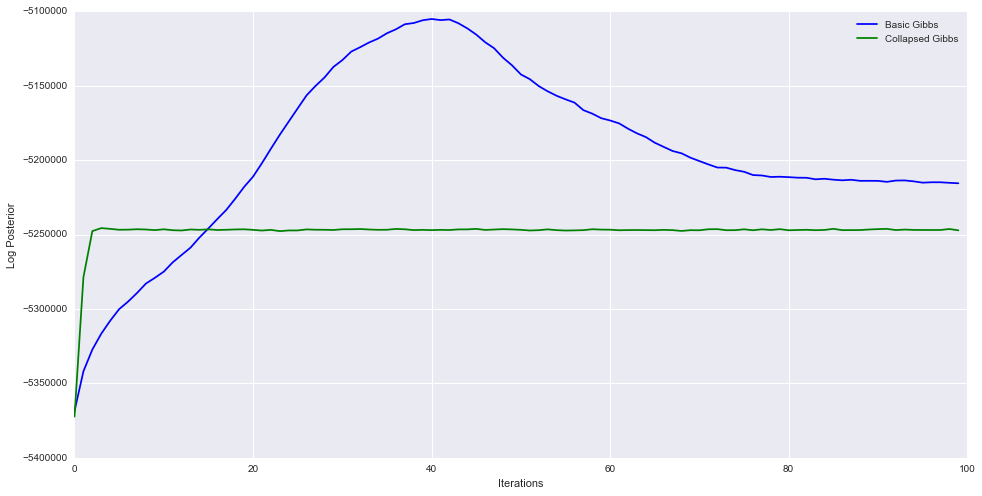

In [18]:
fig = plt.figure(1)
ax = fig.add_subplot(111)

c1, = ax.plot(xrange(100), ps, color="blue", label="Basic Gibbs")
c2, = ax.plot(xrange(100), c_ps, color="green", label="Collapsed Gibbs")

ax.legend(handles=[c1, c2], loc=0)

plt.xlabel('Iterations')
plt.ylabel('Log Posterior')
plt.show()

## Collapsed PDTM

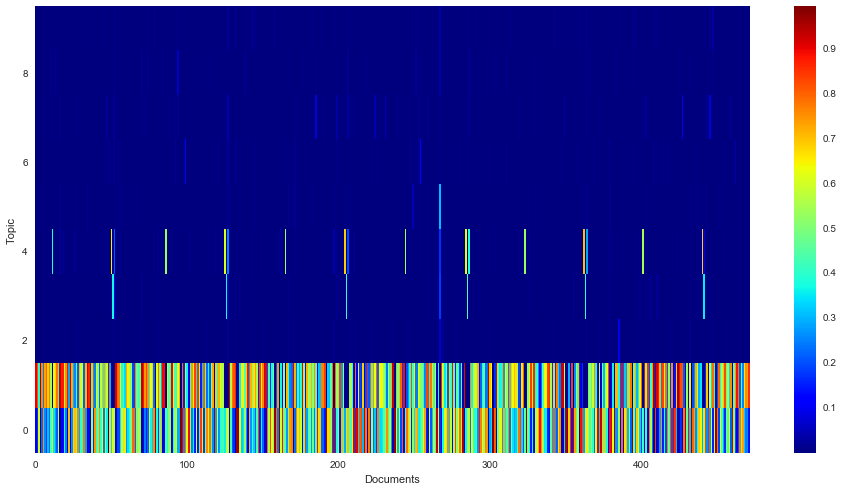

In [15]:
# per-document-topic distributions  PDTM?
pdtm = np.zeros((K,D))  

resample_pdtm(D, alphas, pdtm)

fig2 = plt.figure("Per Document Topic Mixtures")
ax2 = fig2.add_subplot(111)
ax2.set_xlabel("Documents")
ax2.set_ylabel("Topic")
cax2 = ax2.matshow(pdtm, aspect='auto', cmap = plt.cm.jet, origin='lower')
ax2.grid('off')
ax2.xaxis.set_ticks_position('bottom')
fig2.colorbar(cax2)
plt.show()